# 1.Huấn luyện dữ liệu và lưu thành checkpoint

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu huấn luyện, và tỷ lệ dữ liệu để huấn luyện, còn lại là validate
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w09-04-label',
    'nsm-2023w09-02-label',
    'nsm-2023w09-01-label',
    #'nsm-2023w06-ssh-02-label',
    #'nsm-2023w07-dos-02-label',
    #'nsm-2023w07-01-label',
    #'nsm-2023w07-ftp-02-label',
    #'nsm-2023w07-ftp-04-label',
    #'nsm-2023w07-dos-03-label',
    #'nsm-2023w08-ftp-01-label',
    #'nsm-2023w08-dos-01-label',
]))
# nếu data visualization không hiển thị phần dữ liệu validation thì hạ tỷ lệ train_size_ratio xuống
# đặt để data visualization hiển thị dữ liệu anomaly trên cả 2 tập: train và test
train_size_ratio = 0.8

In [2]:
#@title Nhập tên checkpoint để lưu trữ, trùng với tên file huấn luyện AI Agent testing
checkpoint = '2023W0904'

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-10 14:07:55.544136: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 14:07:57.666634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-10 14:07:57.668353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-10 14:07:57.669426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')
client.log_param(run_id=run.info.run_id, key='checkpoint', value=checkpoint)

2023-03-10 14:08:00,512[INFO][140165439014720-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379
2023-03-10 14:08:01,552[INFO][140165439014720-MainThread] migration.py:__init__(204) Context impl PostgresqlImpl.
2023-03-10 14:08:01,554[INFO][140165439014720-MainThread] migration.py:__init__(211) Will assume transactional DDL.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"} # so 100 trong hinh 4d
n_features = 79   #@param {type:"integer"}

# dataset size la tong so flow trong L_source, lay tu cac file csv da duoc gan nhan va chuan hoa
# dataset size = (n_timesteps_in * train_size) + (n_timesteps_in * test_size) = train dataset size + test dataset size

# generate datasets
#train_size= 500 #@param {type:"integer"}    # la 413 trong hinh la kich thuoc bo du lieu dua vao huan luyen
#test_size = 123  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=110 #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))


total_size = int(L_count.sum()['count()']) // n_timesteps_in
train_size = int(total_size * train_size_ratio)
test_size = total_size - train_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('train_size = ', train_size)
print ('test_size = ', test_size)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in))
L_train[Lpadding_features] = 0
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in))
L_test[Lpadding_features] = 0
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

print ('done loading')

(_prepare_read pid=7468) 2023-03-10 14:08:02,780	WARNING file_meta_provider.py:161 -- Expanding 3 path(s). This may be a HIGH LATENCY operation on some cloud storage services. If the specified paths all point to files and never directories, try rerunning this read with `meta_provider=FastFileMetadataProvider()`.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

label  count()
0    0.0   294949
1    1.0   296937

## Data preview

### L_train preview

In [7]:
L_train[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0         0.0      0.995055         0.0          0.0         0.0         0.0   
1         0.0      0.964028         0.0          0.0         0.0         0.0   
2         0.0      1.000000         0.0          0.0         0.0         0.0   
3         0.0      1.000000         0.0          0.0         0.0         0.0   
4         0.0      0.964028         0.0          0.0         0.0         0.0   
...       ...           ...         ...          ...         ...         ...   
473395    1.0      1.000000         0.0          0.0         0.0         0.0   
473396    1.0      1.000000         0.0          0.0         0.0         0.0   
473397    1.0      1.000000         0.0          0.0         0.0         0.0   
473398    1.0      1.000000         0.0          0.0         0.0         0.0   
473399    1.0      1.000000         0.0          0.0         0.0         0.0   

        bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                    0.0             0.0             1.0          1.0   
1                    0.0             0.0             0.0          0.0   
2                    1.0             1.0             1.0          1.0   
3                    1.0             1.0             1.0          1.0   
4                    0.0             0.0             0.0          0.0   
...                  ...             ...             ...          ...   
473395               1.0             1.0             1.0          1.0   
473396               1.0             1.0             1.0          1.0   
473397               1.0             1.0             1.0          1.0   
473398               1.0             1.0             1.0          1.0   
473399               1.0             1.0             1.0          1.0   

        bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0                1.0          1.0          0.0          1.0              0.0   
1                0.0          0.0          0.0          0.0              0.0   
2                1.0          1.0          1.0          1.0              1.0   
3                1.0          1.0          1.0          1.0              1.0   
4                0.0          0.0          0.0          0.0              0.0   
...              ...          ...          ...          ...              ...   
473395           1.0          1.0          1.0          1.0              1.0   
473396           1.0          1.0          1.0          1.0              1.0   
473397           1.0          1.0          1.0          1.0              1.0   
473398           1.0          1.0          1.0          1.0              1.0   
473399           1.0          1.0          1.0          1.0              1.0   

        bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                    0.0              0.0              0.0        0.000000   
1                    0.0              0.0              0.0        0.000000   
2                    1.0              0.0              1.0        0.999909   
3                    1.0              0.0              1.0        1.000000   
4                    0.0              0.0              0.0        0.000000   
...                  ...              ...              ...             ...   
473395               1.0              0.0              1.0        1.000000   
473396               1.0              0.0              1.0        1.000000   
473397               1.0              0.0              1.0        1.000000   
473398               1.0              0.0              1.0        1.000000   
473399               1.0              0.0              1.0        1.000000   

        bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0         0.988569            0.0               0.0            0.0   
1         0.000000            0.0               0.0            0.0   
2         1.000000            0.0               1.0           

In [8]:
L_train[[LABEL, *features]].describe()

label   ack_flag_cnt     active_max    active_mean  \
count  473400.000000  473400.000000  473400.000000  473400.000000   
mean        0.515486       0.949704       0.207573       0.207573   
std         0.499761       0.164192       0.405570       0.405570   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.964028       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          active_min     active_std  bwd_blk_rate_avg  bwd_byts_b_avg  \
count  473400.000000  473400.000000     473400.000000   473400.000000   
mean        0.207573       0.157362          0.448479        0.450190   
std         0.405570       0.364140          0.499056        0.497513   
min         0.000000       0.000000         -1.000000        0.000000   
25%         0.000000       0.000000          0.000000        0.000000   
50%         0.000000       0.000000          0.000000        0.000000   
75%         0.000000       0.000000          1.000000        1.000000   
max         1.000000       1.000000          1.000000        1.000000   

       bwd_header_len    bwd_iat_max   bwd_iat_mean    bwd_iat_min  \
count   473400.000000  473400.000000  473400.000000  473400.000000   
mean         0.731658       0.699586       0.698289       0.695690   
std          0.443097       0.458443       0.460416       0.463023   
min          0.000000      -1.000000      -1.000000      -1.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          1.000000       1.000000       1.000000       1.000000   
75%          1.000000       1.000000       1.000000       1.000000   
max          1.000000       1.000000       1.000000       1.000000   

         bwd_iat_std    bwd_iat_tot  bwd_pkt_len_max  bwd_pkt_len_mean  \
count  473400.000000  473400.000000    473400.000000     473400.000000   
mean        0.624508       0.698289         0.538920          0.538895   
std         0.484250       0.460416         0.498438          0.498433   
min         0.000000      -1.000000         0.000000          0.000000   
25%         0.000000       0.000000         0.000000          0.000000   
50%         1.000000       1.000000         1.000000          1.000000   
75%         1.000000       1.000000         1.000000          1.000000   
max         1.000000       1.000000         1.000000          1.000000   

       bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg     bwd_pkts_s  \
count    473400.000000    473400.000000   473400.000000  473400.000000   
mean          0.074895         0.504422        0.450182       0.513795   
std           0.263161         0.490883        0.497504       0.458098   
min           0.000000         0.000000        0.000000       0.000000   
25%           0.000000         0.000000        0.000000       0.000000   
50%           0.000000         0.771301        0.000000       0.410371   
75%           0.000000         1.000000        1.000000       1.000000   
max           1.000000         1.000000        1.000000       1.000000   

       bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  cwe_flag_count  \
count       473400.0     473400.000000       473400.0   473400.000000   
mean             0.0          0.538895            0.0        0.000034   
std              0.0          0.498433            0.0        0.005072   
min              0.0          0.000000            0.0        0.000000   
25%              0.0          0.000000            0.0        0.000000   
50%              0.0          1.000000            0.0        0.000000   
75%              0.0          1.000000            0.0        0.000000   
max              0.0          1.000000            0.0        0.761594   

       down_up_ratio  dst_port   ece_flag_cnt   fin_flag_cnt    flow_byts_s  \
count  473400.000000  473400.0  4

In [9]:
DataFrame.from_records(LX_train[0])

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0   0.995055  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0   
1   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3   1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
96  0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
98  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
99  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

     14   15   16        17        18   19   20   21   22        23   24   25  \
0   0.0  0.0  0.0  0.000000  0.988569  0.0  0.0  0.0  0.0  0.964028  1.0  0.0   
1   0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
2   1.0  0.0  1.0  0.999909  1.000000  0.0  1.0  0.0  0.0  0.000000  1.0  0.0   
3   1.0  0.0  1.0  1.000000  0.918468  0.0  1.0  0.0  0.0  0.000000  1.0  0.0   
4   0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
..  ...  ...  ...       ...       ...  ...  ...  ...  ...       ...  ...  ...   
95  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
96  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
97  1.0  0.0  1.0  0.999909  1.000000  0.0  1.0  0.0  0.0  0.000000  1.0  0.0   
98  1.0  0.0  1.0  0.999909  1.000000  0.0  1.0  0.0  0.0  0.000000  1.0  0.0   
99  1.0  0.0  1.0  0.999988  1.000000  0.0  1.0  0.0  0.0  0.000000  1.0  0.0   

          26   27        28        29        30        31   32        33  \
0   0.761594  1.0  1.000000  1.000000  1.000000  1.000000  1.0  0.999129   
1   0.761594  1.0  1.000000  1.000000  1.000000  1.000000  0.0  1.000000   
2   0.761594  1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000   
3   0.761594  1.0  1.000000  1.000000  1.000000  1.000000  1.0  0.997569   
4   0.761594  1.0  1.000000  1.000000  1.000000  1.000000  0.0  1.000000   
..       ...  ...       ...       ...       ...       ...  ...       ...   
95  0.761594  1.0  1.000000  1.000000  1.000000  1.000000  0.0  1.000000   
96  0.761594  1.0  0.999998  0.999998  0.999998  0.999998  0.0  1.000000   
97  0.761594  1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000   
98  0.761594  1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000   
99  0.761594  1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000   

          34   35   36   37        38        39        40   41        42   43  \
0   0.000000  0.0  0.0  1.0  0.000000  0.000000  0.000000  0.0  0.000000  1.0   
1   0.000000  0.0  0.0  1.0  1.000000  1.000000  1.000000  0.0  1.000000  1.0   
2   0.995055  0.0  0.0  1.0  1.000000  1.000000  1.000000  1.0  1.000000  1.0   
3   0.999329  0.0  0.0  1.0  1.000000  1.000000  1.000000  1.0  1.000000  1.0   
4   0.000000  0.0  0.0  1.0  1.000000  1.000000  1.000000  0.0  1.000000  1.0   
..       ...  ...  ...  ...       ...       ...       ...  ...       ...  ...   
95  0.000000  0.0  0.0  1.0  1.000000  1.000000  1.000000  0.0  1.000000  1.0   
96  0.000000  0.0  0.0  1.0  0.999998  0.999998  0.999998  0.0  0.999998  1.0   
97  0.995055  0.0  0.0  1.0  1.000000  1.000000  1.000000  1.0  1.000000  1.0   
98  0.995055  0.0  0.0  1.0  1.000000  1.000000  1.000000  1.0  1.000000  1.0   
99  0.995055  0.0  0.0  1.0  1.000000  1.000000  1.000000  1.0  1.000000  1.0   

     44   45   46   47        48        49   50   51   52   53   54   55   56  \
0   1.0  1.0  0.0  0.0  0.859049  0.761594  1.0  1.0  0.0  1.0  1.0  1.0  0.0   
1   1.0  0.0  1.

In [10]:
DataFrame.from_records(LX_train[0]).describe()

0           1           2           3           4           5   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.990852    0.180000    0.180000    0.180000    0.070000    0.650000   
std      0.015588    0.386123    0.386123    0.386123    0.256432    0.479372   
min      0.964028    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.987298    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
75%      1.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.650000    0.750000    0.730000    0.730000    0.729951    0.710000   
std      0.479372    0.435194    0.446196    0.446196    0.446166    0.456048   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.750000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.730000    0.700000    0.700000    0.050000    0.650000    0.649959   
std      0.446196    0.460566    0.460566    0.219043    0.479372    0.479342   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    0.000000    1.000000    0.999909   
75%      1.000000    1.000000    1.000000    0.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18     19          20     21     22          23     24     25  \
count  100.000000  100.0  100.000000  100.0  100.0  100.000000  100.0  100.0   
mean     0.656287    0.0    0.700000    0.0    0.0    0.166318    1.0    0.0   
std      0.450436    0.0    0.460566    0.0    0.0    0.326028    0.0    0.0   
min      0.000000    0.0    0.000000    0.0    0.0    0.000000    1.0    0.0   
25%      0.024955    0.0    0.000000    0.0    0.0    0.000000    1.0    0.0   
50%      0.984144    0.0    1.000000    0.0    0.0    0.000000    1.0    0.0   
75%      1.000000    0.0    1.000000    0.0    0.0    0.000000    1.0    0.0   
max      1.000000    0.0    1.000000    0.0    0.0    0.995055    1.0    0.0   

               26          27          28          29          30          31  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.719947    0.969123    1.000000    1.000000    1.000000    0.999567   
std      0.185011    0.169472    0.000001    0.000001    0.000001    0.003625   
min      0.000000    0.000000    0.999988    0.999988    0.999988    0.964028   
25%      0.761594    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      0.761594    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      0.761594    1.000000    1.000000    1.000000    1.000000    1.000000   
max      0.964028    1.000000    1.000000    1.000000    1.000000    1.000000   

               32          33          34     35     36     37          38  \
count  100.000000  100.000000  100.000000  100.0  100.0  100.0  100.000000   
mean     0.750000    0.936871    0.723848    0.0    0.0    1.0    0.970000   
std      0.435194    0.218509    0.443097    0.0    0.0    0.0    0.171447   
min      0.000000    0.066473    0.000000    0.0    0.0    1.0

In [11]:
DataFrame.from_records(Ly_train)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4729  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4730  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4731  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4732  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4733  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0   

       14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4729  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4730  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4731  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4732  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4733  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   

       28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4729  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4730  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4731  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4732  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4733  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

       42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4729  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4730  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4731  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4732  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4733  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

       56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0 

In [12]:
DataFrame.from_records(Ly_train).describe()

0            1            2            3            4   \
count  4734.000000  4734.000000  4734.000000  4734.000000  4734.000000   
mean      0.520068     0.523236     0.509506     0.508238     0.512041   
std       0.499650     0.499513     0.499962     0.499985     0.499908   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                5            6            7            8            9   \
count  4734.000000  4734.000000  4734.000000  4734.000000  4734.000000   
mean      0.525137     0.524504     0.516477     0.514364     0.514998   
std       0.499420     0.499452     0.499781     0.499846     0.499828   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                10           11           12           13           14  \
count  4734.000000  4734.000000  4734.000000  4734.000000  4734.000000   
mean      0.508027     0.517744     0.510984     0.519645     0.522814   
std       0.499988     0.499738     0.499932     0.499667     0.499532   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                15           16           17           18           19  \
count  4734.000000  4734.000000  4734.000000  4734.000000  4734.000000   
mean      0.510351     0.508661     0.513308     0.513519     0.515843   
std       0.499946     0.499978     0.499876     0.499870     0.499802   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                20           21           22           23           24  \
count  4734.000000  4734.000000  4734.000000  4734.000000  4734.000000   
mean      0.508450     0.510139     0.513097     0.512674     0.519645   
std       0.499981     0.499950     0.499881     0.499892     0.499667   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                25           26          27           28           29  \
count  4734.000000  4734.000000  4734.00000  4734.000000  4734.000000   
mean      0.507816     0.514998     0.51711     0.515420     0.513730   
std       0.499992     0.499828     0.49976     0.499815     0.499864   
min       0.000000     0.000000     0.00000     0.000000     0.000000   
25%       0.000000     0.000000     0.00000     0.000000     0.000000   
50%       1.000000     1.000000     1.00000     1.000000     1.000000   
75%       1.000000     1.000000     1.00000     1.000000     1.000000   
max       1.000000     1.000000     1.00000     1.000000     1.000000   

                30     

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_train'], IMG['Ly_train'], IMG['LX_test'], IMG['Ly_test'] = ray.get([
    show_scattered_4d.remote(LX_train, 'LX_train'),
    show_scattered_4d.remote(Ly_train, 'Ly_train'),
    show_scattered_4d.remote(LX_test, 'LX_test'),
    show_scattered_4d.remote(Ly_test, 'Ly_test'),
])

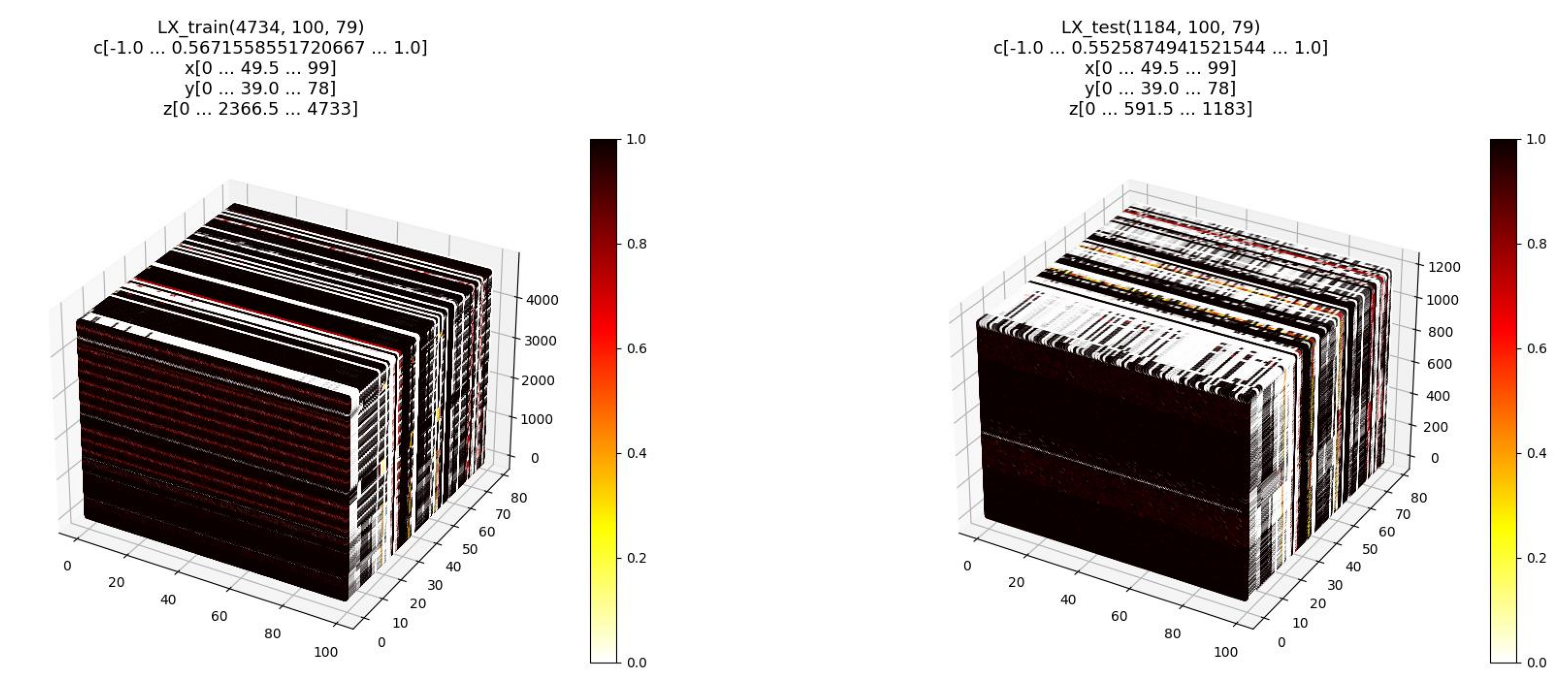

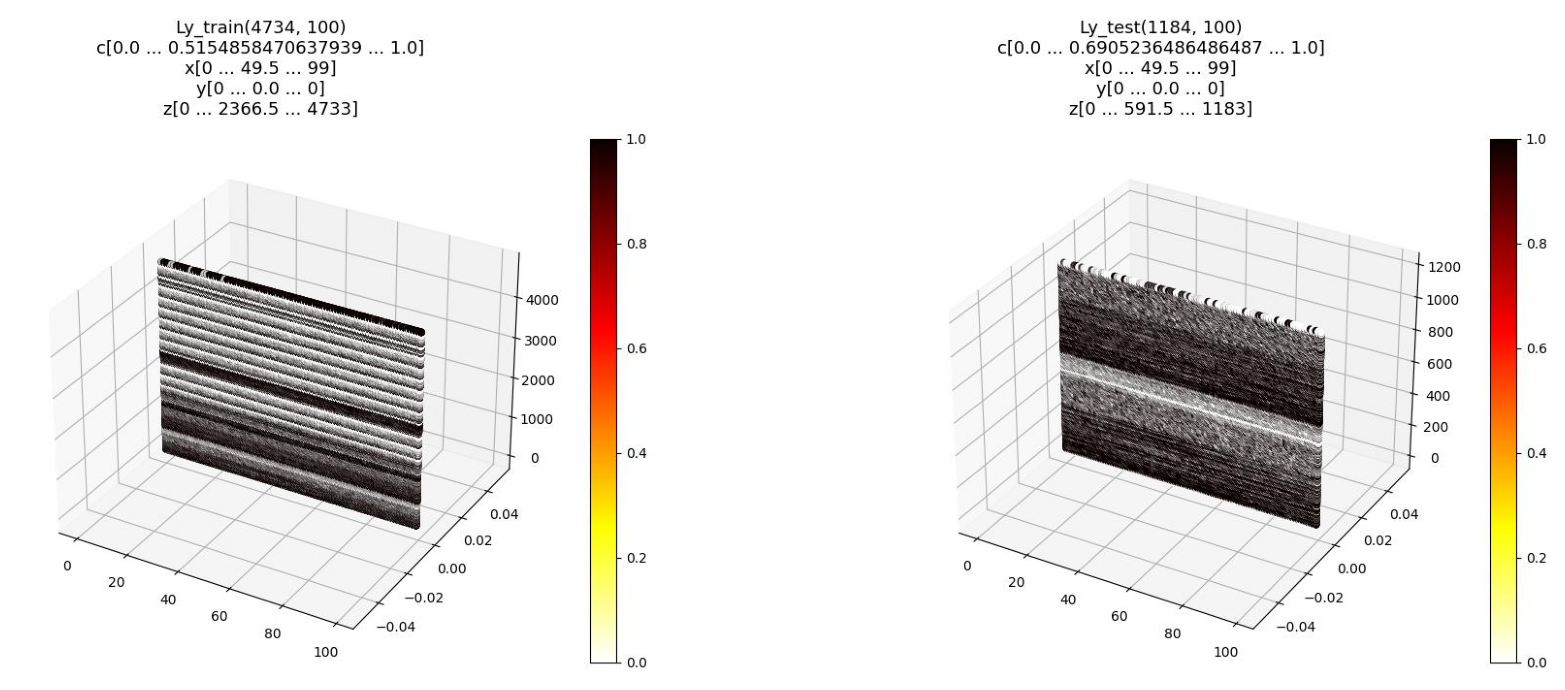

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_train','LX_test'])
show_4d_imgs(['Ly_train','Ly_test'])

# 4.INTRODUCTION

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.
To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

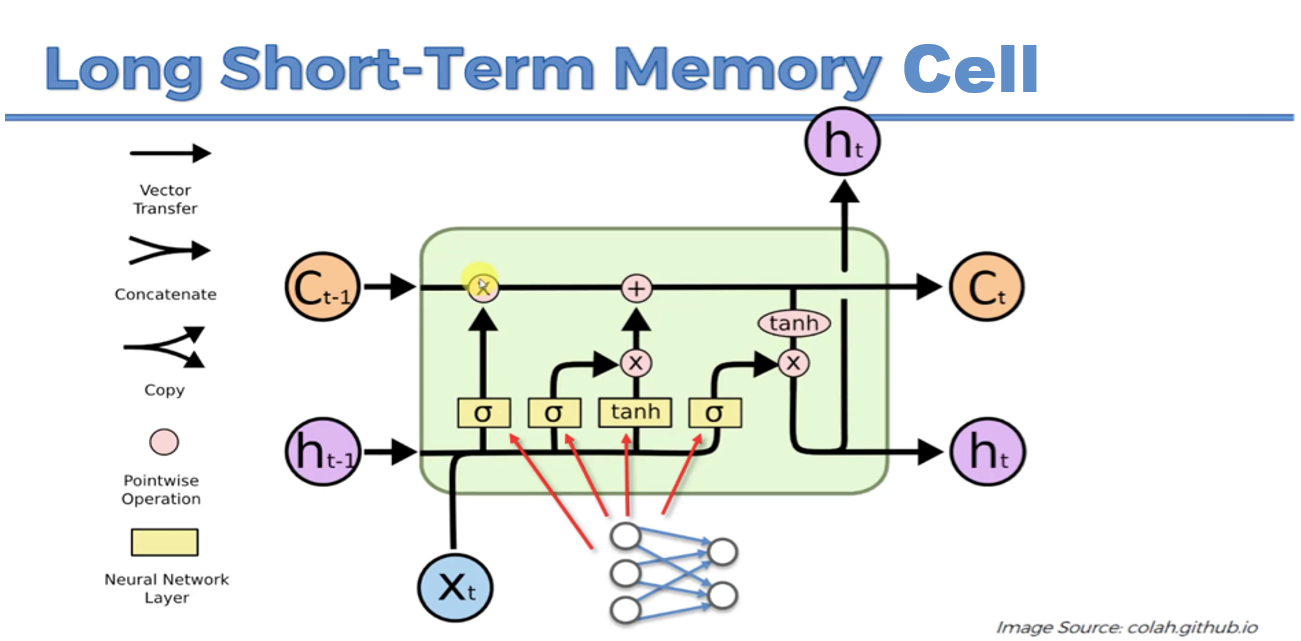

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

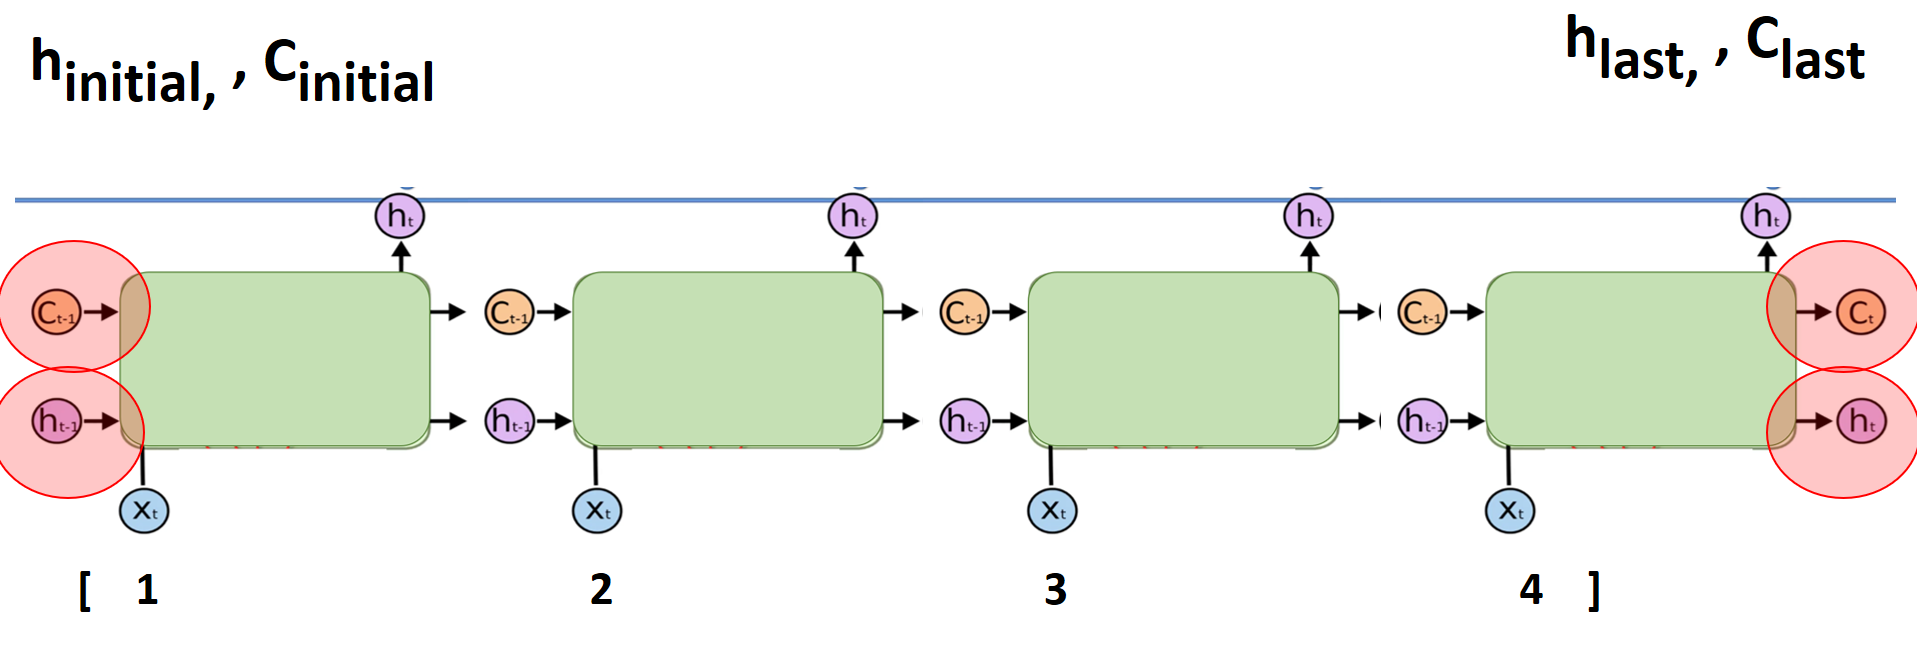

# 5.Train function

In [15]:
#@title train function

def train(model, name='model6'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_train, Ly_train, batch_size=batch_size, epochs=epochs, validation_data=(LX_test, Ly_test))
  show_train_metric(history, name)
  model.save(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  open(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}/features.json", "w").write(json.dumps(features))
  common.saving_checkpoint_to_mlflow(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")

In [16]:
#@title infer function
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
  model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  ##############LX_train
  L_result1=model.predict(LX_train)
  train_predicted = np.vectorize(threshold)(L_result1)
  print(f"Ly_train_predicted/Ly_train = {train_predicted.sum()}/{Ly_train.sum()}")

  ##############LX_test
  L_result2=model.predict(LX_test)
  test_predicted = np.vectorize(threshold)(L_result2)
  print(f"Ly_test_predicted/Ly_test = {test_predicted.sum()}/{Ly_test.sum()}")

  IMG['Ly_train_predicted'], IMG['Ly_test_predicted'] = ray.get([
    show_scattered_4d.remote(L_result1, "Ly_train_predicted"),
    show_scattered_4d.remote(L_result2, "Ly_test_predicted"),
  ])
  show_4d_imgs(['LX_train','Ly_train','Ly_train_predicted'])
  show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])


___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [17]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

2023-03-10 14:43:13.702685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-10 14:43:13.704032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-10 14:43:13.705168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-03-10 14:43:13.706222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 79)]        0         
                                                                 
 dense1 (Dense)              (None, None, 230)         18400     
                                                                 
 lstm (LSTM)                 [(None, None, 320),       705280    
                              (None, 320),                       
                              (None, 320)]                       
                                                                 
 values (Dense)              (None, None, 1)           321       
                                                                 
Total params: 724,001
Trainable params: 724,001
Non-trainable params: 0
_________________________________________________________________


## 6.2.Train



Epoch 1/110


2023-03-10 14:43:46.592925: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-10 14:43:48.788349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


148/148 [==============================] - 29s 19ms/step - loss: 0.2204 - accuracy: 0.9136 - val_loss: 0.1054 - val_accuracy: 0.9692
Epoch 2/110
148/148 [==============================] - 2s 15ms/step - loss: 0.0673 - accuracy: 0.9829 - val_loss: 0.0958 - val_accuracy: 0.9737
Epoch 3/110
148/148 [==============================] - 2s 15ms/step - loss: 0.0545 - accuracy: 0.9853 - val_loss: 0.0845 - val_accuracy: 0.9749
Epoch 4/110
148/148 [==============================] - 2s 15ms/step - loss: 0.0484 - accuracy: 0.9867 - val_loss: 0.0779 - val_accuracy: 0.9757
Epoch 5/110
148/148 [==============================] - 2s 15ms/step - loss: 0.0436 - accuracy: 0.9875 - val_loss: 0.0782 - val_accuracy: 0.9768
Epoch 6/110
148/148 [==============================] - 2s 15ms/step - loss: 0.0414 - accuracy: 0.9886 - val_loss: 0.0702 - val_accuracy: 0.9789
Epoch 7/110
148/148 [==============================] - 2s 15ms/step - loss: 0.0369 - accuracy: 0.9901 - val_loss: 0.0603 - val_accuracy: 0.9805
Epo

2023-03-10 14:47:56.009187: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


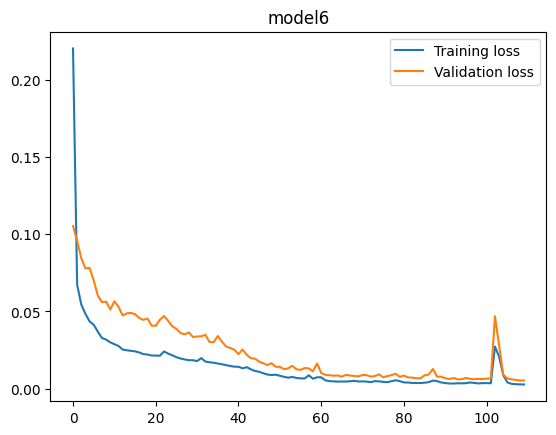

In [18]:
train(model6)

## 6.3.Infer



Ly_train_predicted/Ly_train = 244233/244031.0
Ly_test_predicted/Ly_test = 81860/81758.0


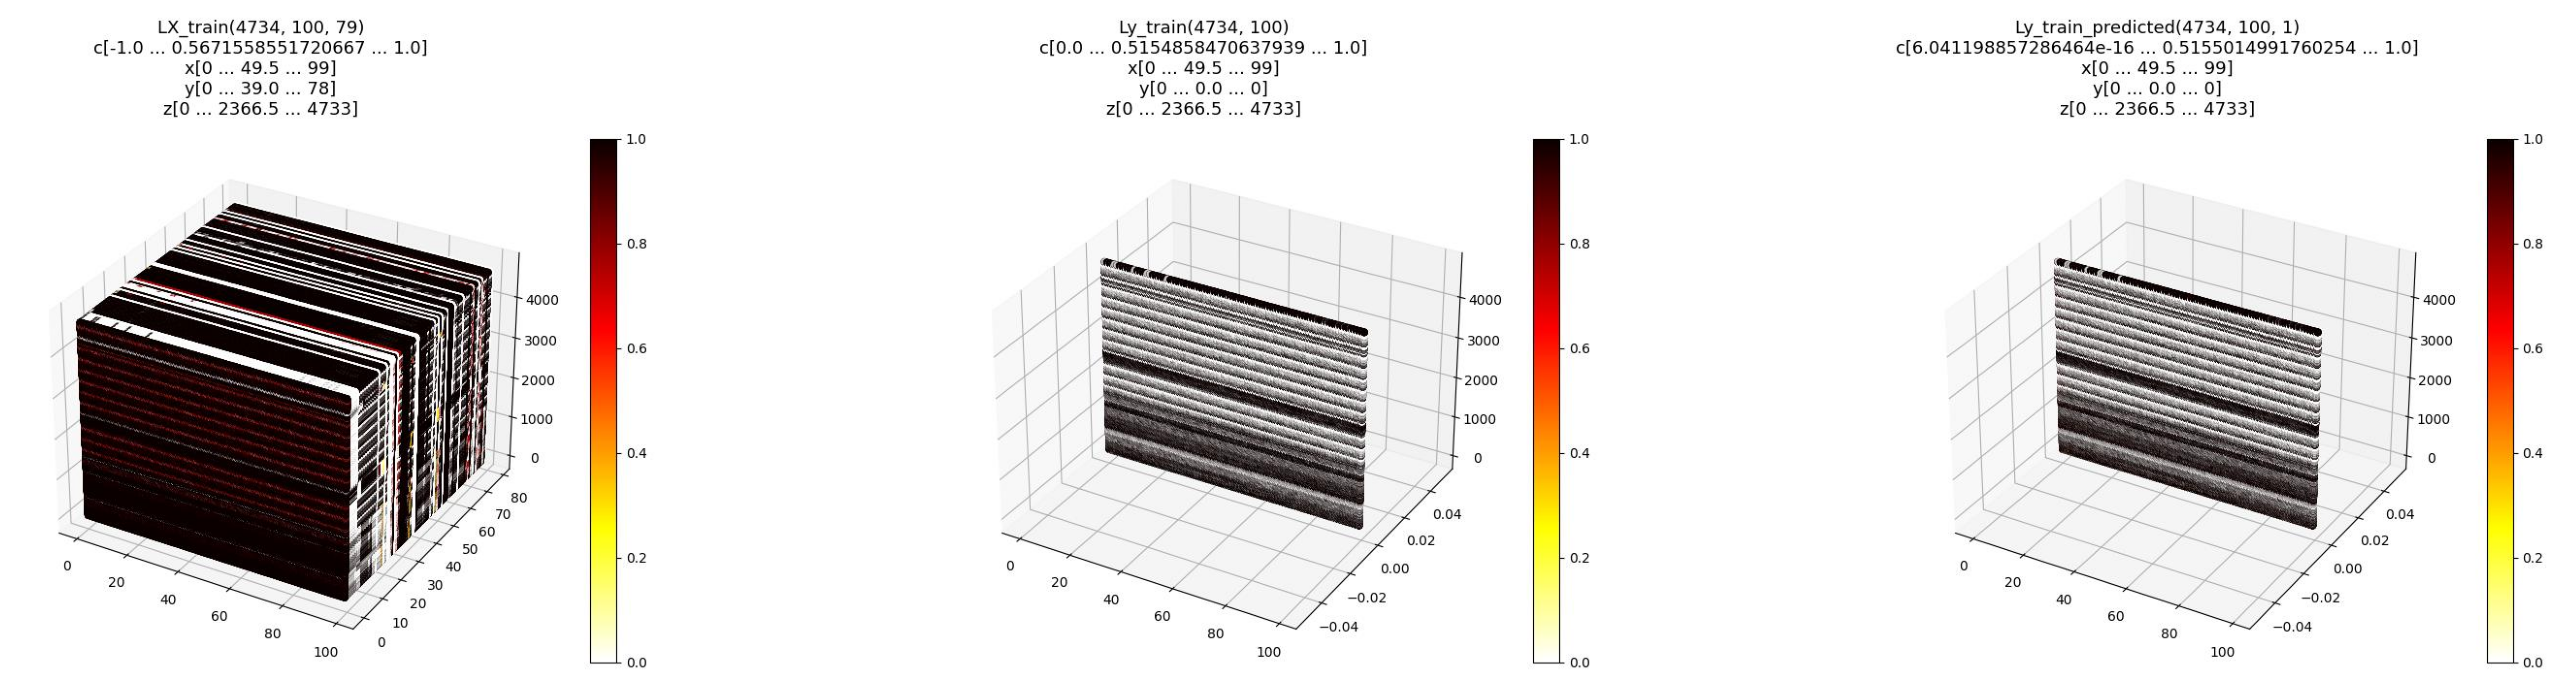

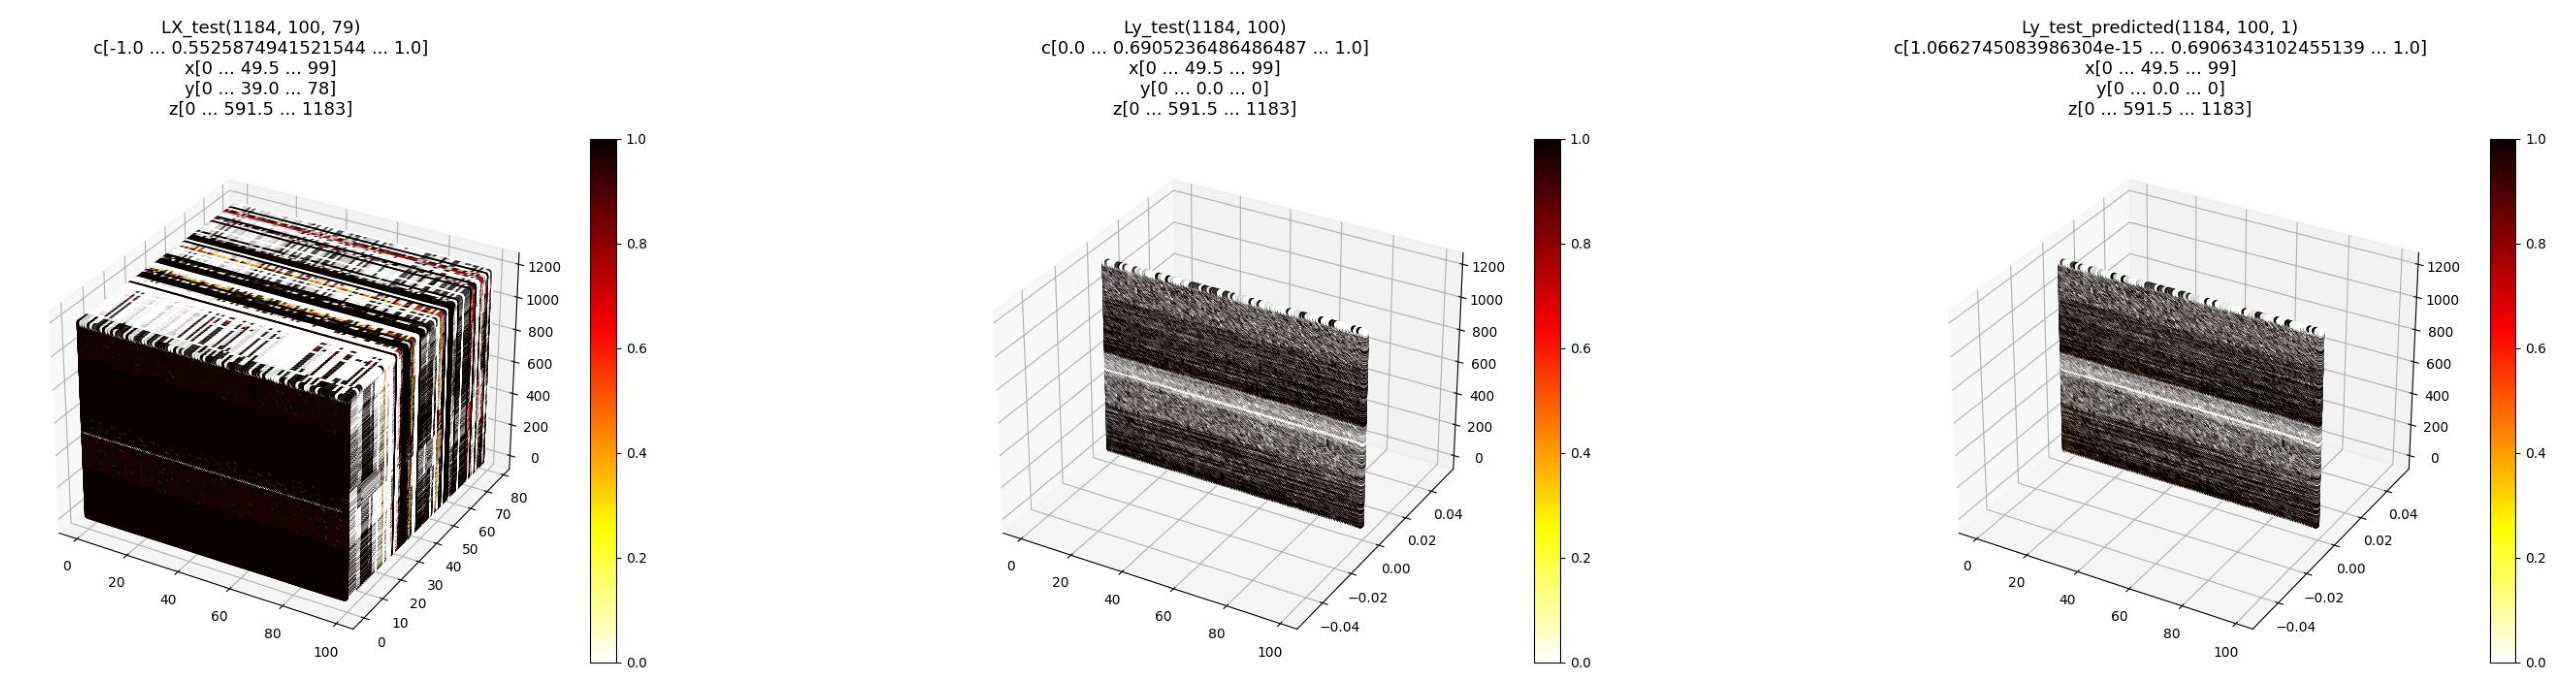

In [19]:
infer_by_checkpoint(checkpoint)

# 7.MODEL WEIGHTS SUMMARY

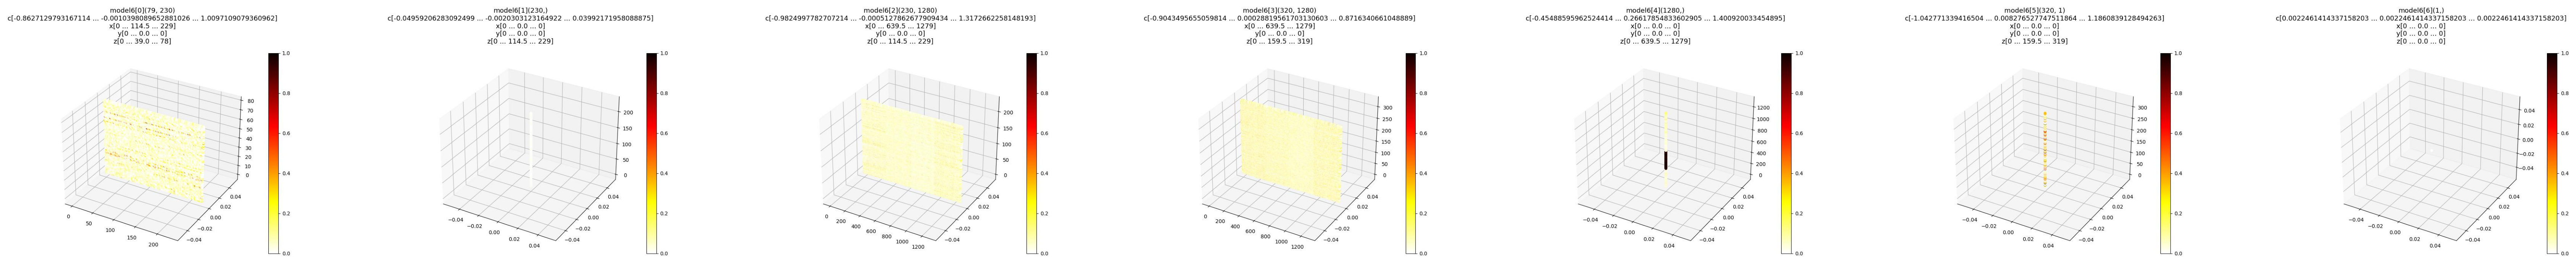

In [20]:
weights6 = show_weights(model6, 'model6')
show_4d_imgs(weights6)